# Evaluation (Citeseer)

In [1]:
%load_ext autoreload
%load_ext memory_profiler
%autoreload 2

!mkdir ./cache
!mkdir ./cache/citeseer

mkdir: cannot create directory ‘./cache’: File exists
mkdir: cannot create directory ‘./cache/citeseer’: File exists


In [2]:
from impl.datasets.citeseer import Citeseer
from impl.pairs.doc2vec import D2VPairs
from impl.pairs.deepwalk import DWPairs
from impl.model.skipgram import SGNS
from impl.model.jce import JCE
from impl.utils.eval import eval_model, plot_evals
from gensim.models import Word2Vec, doc2vec
import numpy as np
import psutil

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Use importlib.util.find_spec() instead.
  """Entry point for launching an IPython kernel.


## Dataset

In [3]:
dataset = Citeseer(content_filename='./datasets/citeseer/citeseer.content', cites_filename='./datasets/citeseer/citeseer.cites')

print("Tagged docs: ", dataset.get_tagged_docs()[0:2])

Get tagged docs: 3312it [00:03, 935.26it/s]

Tagged docs:  [TaggedDocument(words=['36', '46', '65', '215', '261', '565', '1162', '1508', '1613', '1641', '1662', '1797', '1842', '1988', '2025', '2399', '2456', '2521', '2597', '2618', '2641', '2902', '3016', '3050', '3163', '3268', '3272', '3287', '3411', '3447', '3669'], tags=['100157']), TaggedDocument(words=['31', '102', '147', '168', '211', '410', '505', '543', '579', '650', '900', '981', '1029', '1160', '1329', '1511', '1583', '1605', '1842', '1915', '1987', '2065', '2085', '2216', '2266', '2284', '2374', '2429', '2468', '2474', '2544', '2568', '2570', '2594', '2609', '2699', '2717', '2976', '2977', '3203'], tags=['100598'])]


## Parameters

In [4]:
run_d2v = True
run_dw = True
run_jce = True
cache = True

params_d2v = {
   "pairs": {
       "neg_samples": 10,
       "sample": 0,
       "min_count": 5
   },
   "model": {
       "dim": 100,
       "alpha": 0.001,
       "iterations": 10,
       "batch_size": 4,
       "cache_file": "./cache/citeseer/d2v"
   }
}

params_dw = {
   "pairs": {
       "neg_samples": 10,
       "sample": 0.001,
       "min_count": 5,
       "walk_length": 40,
       "num_walks": 10,
       "window_size": 5
   },
   "model": {
       "dim": 100,
       "alpha": 0.001,
       "iterations": 10,
       "batch_size": 500,
       "cache_file": "./cache/citeseer/dw"
   }
}

params_jce_concat = {
    "dim": 200,
    "alpha": 0.001,
    "iterations": 10,
    "batch_sizes": [params_d2v["model"]["batch_size"],params_dw["model"]["batch_size"]],
    "cache_file": "./cache/citeseer/jce_concat"
}
params_jce_compare = {
    "dim": 100,
    "alpha": 0.001,
    "iterations": 10,
    "batch_sizes": [params_d2v["model"]["batch_size"],params_dw["model"]["batch_size"]],
    "cache_file": "./cache/citeseer/jce_compare"
}
params_jce_sine = {
    "dim": 100,
    "alpha": 0.001,
    "iterations": 10,
    "batch_sizes": [params_d2v["model"]["batch_size"],params_dw["model"]["batch_size"]],
    "cache_file": "./cache/citeseer/jce_sine"
}

## Input Pairs

In [5]:
d2vpairs = D2VPairs(dataset=dataset, **params_d2v["pairs"])
dwpairs = DWPairs(dataset=dataset, **params_dw["pairs"])

DeepWalk: Generate walks:   0%|          | 0/10 [00:00<?, ?it/s]

Removed 15 unknown nodes


DeepWalk: Generate walks: 100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


## Doc2Vec

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval D2V:  [(0.6376255633797702, 0.010772667293791113), (0.6955917874396136, 0.009753677323727035)]


Evaluating model: 100%|██████████| 10/10 [01:10<00:00,  7.06s/it]


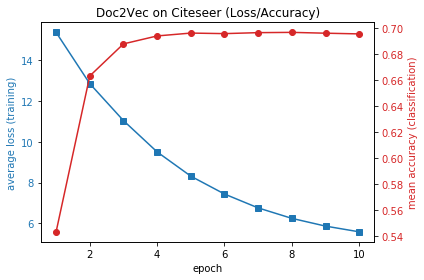

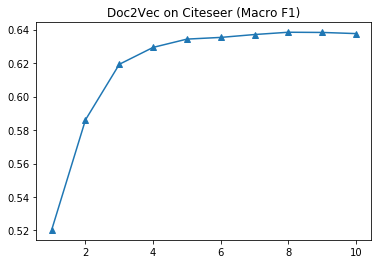

In [6]:
if run_d2v:
    d2vmodel = SGNS(d2vpairs, cache=cache, **params_d2v["model"])
    d2vemb = d2vmodel.embeddings[str(params_d2v["model"]["iterations"])]

    print("Eval D2V: ", eval_model(d2vemb, dataset=dataset))
    # gensim_d2v = doc2vec.Doc2Vec(dataset.get_tagged_docs(), negative=params_d2v["pairs"]["neg_samples"], sample=params_d2v["pairs"]["sample"], min_count=params_d2v["pairs"]["min_count"], vector_size=params_d2v["model"]["dim"], epochs=params_d2v["model"]["iterations"], dm=1, hs=0, alpha=params_d2v["model"]["alpha"])
    # print("Eval Gensim D2V: ", eval_model(gensim_d2v.docvecs, dataset=dataset))
    
    plot_evals(d2vmodel, title="Doc2Vec on Citeseer", dataset=dataset)

## DeepWalk

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval DW:  [(0.5303583478701555, 0.007376886942726614), (0.5789251207729467, 0.008218108739594847)]


Evaluating model: 100%|██████████| 10/10 [01:10<00:00,  7.00s/it]


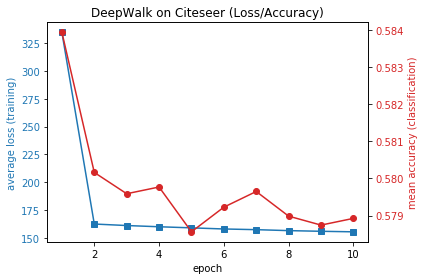

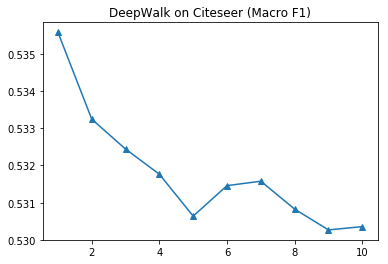

In [7]:
if run_dw:
    dwmodel = SGNS(dwpairs, cache=cache, **params_dw["model"])
    dwemb = dwmodel.embeddings[str(params_dw["model"]["iterations"])]

    print("Eval DW: ", eval_model(dwemb, dataset=dataset))
    # gensim_w2v = Word2Vec(dwpairs.sentences, negative=params_dw["pairs"]["neg_samples"], sample=params_dw["pairs"]["sample"], min_count=params_dw["pairs"]["min_count"], size=params_dw["model"]["dim"], iter=params_dw["model"]["iterations"], window=params_dw["pairs"]["window_size"], sg=1, alpha=params_dw["model"]["alpha"], hs=0, compute_loss=True)
    # print("Eval Gensim DW: ", eval_model(gensim_w2v.wv, dataset=dataset))
    
    plot_evals(dwmodel, title="DeepWalk on Citeseer", dataset=dataset)

## DW+D2V

Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval D2VDW:  [(0.6457021596869524, 0.0076550902557891405), (0.6909722222222222, 0.006163784922280677)]


Evaluating model: 100%|██████████| 10/10 [01:57<00:00, 11.78s/it]


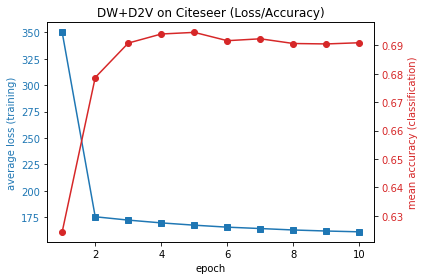

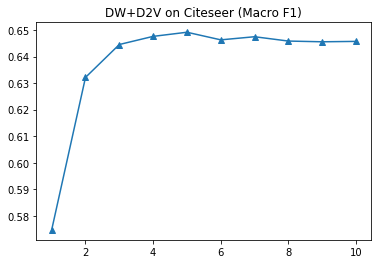

In [8]:
if run_d2v and run_dw:
    class D2VDWModel:
        def __init__(self):
            self.embeddings = dict()
            self.losses = dict()
    
    d2vdwmodel = D2VDWModel()
    
    for epoch in d2vmodel.embeddings.keys():
        d2v_emb_epoch = d2vmodel.embeddings[epoch]
        dw_emb_epoch = dwmodel.embeddings[epoch]
        d2v_loss_epoch = d2vmodel.losses[epoch]
        dw_loss_epoch = dwmodel.losses[epoch]
        
        d2vdwmodel.embeddings[epoch] = dict()
        for k in d2v_emb_epoch.keys():
            a = d2v_emb_epoch[k]
            b = dw_emb_epoch[k]
            d2vdwmodel.embeddings[epoch][k] = np.concatenate((a, b))
        d2vdwmodel.losses[epoch] = d2v_loss_epoch + dw_loss_epoch
    
    print("Eval D2VDW: ", eval_model(d2vdwmodel.embeddings['10'], dataset=dataset))
    plot_evals(d2vdwmodel, title="DW+D2V on Citeseer", dataset=dataset)

## JCE-CNC

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE (Concat):  [(0.618808837501037, 0.010558028097472937), (0.6631340579710144, 0.007799620793200453)]


Evaluating model: 100%|██████████| 10/10 [02:01<00:00, 12.10s/it]


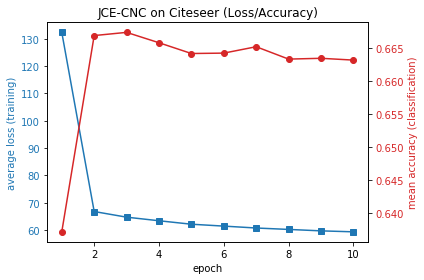

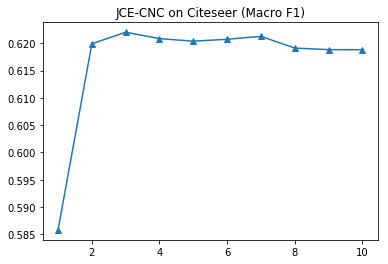

In [9]:
if run_jce:
    jceemb_concat = JCE(data=[d2vpairs, dwpairs], cache=cache, **params_jce_concat)

    print("Eval JCE (Concat): ", eval_model(jceemb_concat.embeddings[str(params_jce_concat["iterations"])], dataset=dataset))
    plot_evals(jceemb_concat, title="JCE-CNC on Citeseer", dataset=dataset)

## JCE-CMP

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE (Compare):  [(0.6309260868789771, 0.012799330139616904), (0.6784420289855073, 0.010830074531802453)]


Evaluating model: 100%|██████████| 10/10 [01:28<00:00,  8.83s/it]


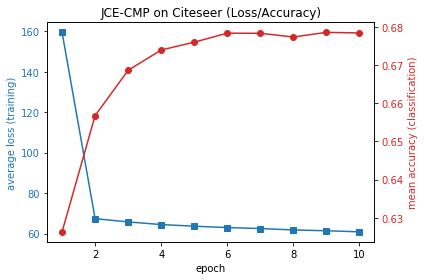

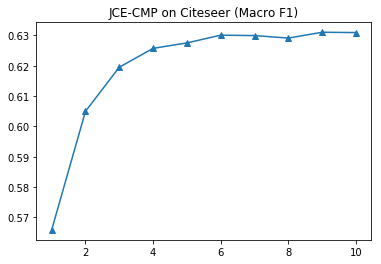

In [10]:
if run_jce:
    jceemb_compare = JCE(data=[d2vpairs, dwpairs], cache=cache, **params_jce_compare)

    print("Eval JCE (Compare): ", eval_model(jceemb_compare.embeddings[str(params_jce_compare["iterations"])], dataset=dataset))
    plot_evals(jceemb_compare, title="JCE-CMP on Citeseer", dataset=dataset)

## JCE-DW/JCE-D2V

Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE-D2V:  [(0.4683788177851409, 0.012987857558523616), (0.5093900966183574, 0.011236550054139652)]


Evaluating model: 100%|██████████| 10/10 [01:01<00:00,  6.18s/it]


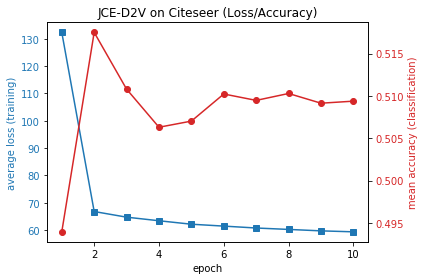

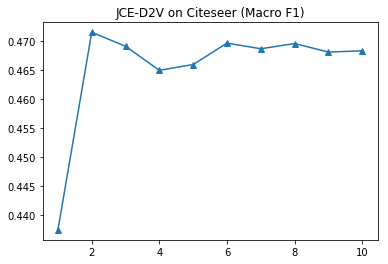

Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE-DW:  [(0.506119068095265, 0.0072853265294691065), (0.55625, 0.006741345864615805)]


Evaluating model: 100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


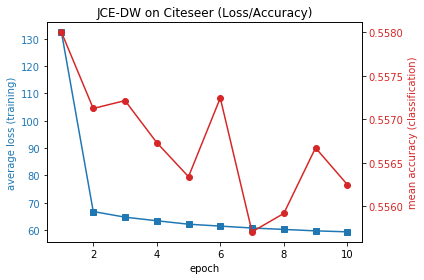

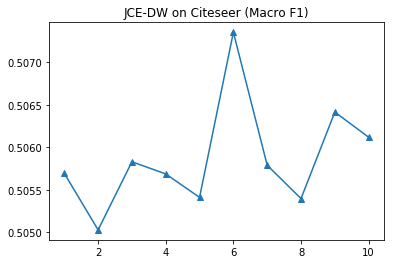

In [11]:
if run_jce:
    class JCESplitModel:
        def __init__(self):
            self.embeddings = dict()
            self.losses = dict()
    
    d2vjcemodel = JCESplitModel()
    dwjcemodel = JCESplitModel()
    
    for epoch in jceemb_concat.embeddings.keys():
        jceemb_epoch = jceemb_concat.embeddings[epoch]
        jceloss_epoch = jceemb_concat.losses[epoch]
                
        d2vjcemodel.embeddings[epoch] = dict()
        dwjcemodel.embeddings[epoch] = dict()
        for k in jceemb_epoch.keys():
            a = jceemb_epoch[k]
            half = len(a)//2
            d2vjcemodel.embeddings[epoch][k] = a[:half]
            dwjcemodel.embeddings[epoch][k] = a[half:]
        d2vjcemodel.losses[epoch] = jceloss_epoch
        dwjcemodel.losses[epoch] = jceloss_epoch
    
    print("Eval JCE-D2V: ", eval_model(d2vjcemodel.embeddings['10'], dataset=dataset))
    plot_evals(d2vjcemodel, title="JCE-D2V on Citeseer", dataset=dataset)
    
    print("Eval JCE-DW: ", eval_model(dwjcemodel.embeddings['10'], dataset=dataset))
    plot_evals(dwjcemodel, title="JCE-DW on Citeseer", dataset=dataset)

## SINE(Reprod.)

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE (SINE):  [(0.6349175432372312, 0.009401769371387527), (0.6909722222222221, 0.007476408768858769)]


Evaluating model: 100%|██████████| 10/10 [01:06<00:00,  6.66s/it]


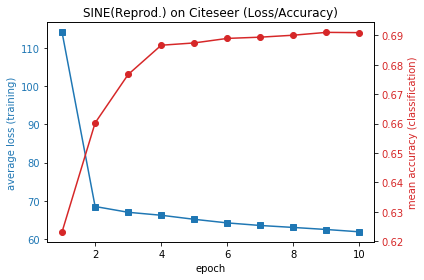

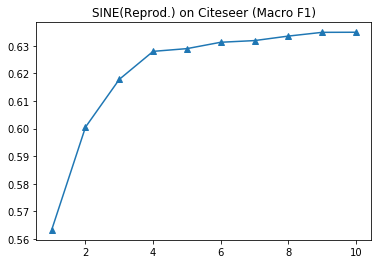

In [12]:
if run_jce:
    jceemb_sine = JCE(data=[d2vpairs, dwpairs], cache=cache, disable_grad=False, **params_jce_sine)

    print("Eval JCE (SINE): ", eval_model(jceemb_sine.embeddings[str(params_jce_sine["iterations"])], dataset=dataset))
    plot_evals(jceemb_sine, title="SINE(Reprod.) on Citeseer", dataset=dataset)